# First analysis of precocity results

This is a first pass, using an old topic model, and is missing several metadata categories. But it may give us a sense of the structure of the problem and the sorts of questions we'll encounter when we do the final analysis.



In [69]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, pearsonr, spearmanr, zscore
from statistics import mean, stdev
from math import sqrt
import seaborn as sns

The results I'll use here were created by comparing books forward and backward using KL divergence, which is what Barron et al. do and what we preregistered. But the directory also includes results measured with cosine distance.

In any case we load them in the next cell. 

### Load the novelty / precocity results

The name "centersurprise" is because KLD/surprise is asymmetric and this is organized the same way Barron et al do it, where the books in the past (or future) are the reference point and the book in the center of the timeline is being compared to them.

In [75]:
results = pd.read_csv('centersurprise_0summary.tsv', sep = '\t', low_memory = False)

In [76]:
results.shape

(5494, 7)

In [77]:
results.head()

,docid,novelty_1.0_25,novelty_0.05_25,transience_1.0_25,transience_0.05_25,resonance_1.0_25,resonance_0.05_25
0,uc1.b3347126,3.398059,1.821735,3.085248,1.549357,0.312811,0.272377
1,uc1.$b322688,3.135666,1.553544,2.814364,1.401104,0.321302,0.152440
2,uc1.b3407035,3.867555,2.192431,3.812988,2.240488,0.054567,-0.048057
3,uc1.$b116192,3.191707,1.829873,3.215412,1.836419,-0.023705,-0.006546
4,mdp.39015059415383,2.742098,1.313322,2.462502,1.264870,0.279596,0.048452


The columns with 1.0 are measured with respect to all volumes in a year. The columns with .05 are measured with respect to the 5% of most similar books (excluding books with the same author — and we're quite careful to exclude them, using fuzzy matching so we exclude them even if spelling is slightly different.

All the columns are measured in a 25-year window, which means we consider *all* the volumes from 1 year back to 25 years back, etc.

The thing labeled here as "resonance" is what we're calling "precocity." I haven't changed the term in the python script yet.

I only calculated results for the 5494 volumes in metadata. 

### Now load metadata

This file contains both regular metadata and some summary statistics about reception generated in the ```FuseMeta.ipynb``` notebook. For instance, we know for each book whether its author was in Liza's lists of prizewinning authors and whether the book itself was a bestseller. 

For books that were matched toWe also know the total review wordcount and the average review sentiment, although I caution that this estimate is a bit unreliable because sentiment is missing in many cases. In the final version we might train a model to estimate it for those cases.

Finally, there's a column called ```obscure.``` **This is an important tricky detail.** The volumes in metadata are mostly volumes from the topic model that I was able to match book reviews. (I'm not using other volumes in Hathi that match the book reviews because this topic model doesn't have an inferencer.)

But I also included a thousand volumes that were in the model but *not* matched to reviews. They might have been missed in the matching process, but many of these are probably things that didn't get reviewed or at any rate didn't get summarized in *Book Review Digest.* They are thus *likely* to be more obscure than the reviewed volumes. Probably a fair comparison would include more of these potentially-obscure volumes, not just a sample of one thousand. I was working quickly in an effort to get some results.

In [78]:
meta = pd.read_csv('bookswithreception.tsv', sep = '\t')

In [79]:
meta.head(3)

,docid,tm_author,tm_title,tm_year,review_year,rownum,review_title,prize_author,bestseller_year,is_bestseller,obscure,firstpub,birthyear,us_national,lowest_date,standard_auth,review_wordcount,review_sentiment
0,uc1.b3347126,"shaw, irwin","welcome to the city, and other",1942.0,1942.0,3289.0,"welcome to the city, and other stories.",False,NaN,False,False,1942,1913.0,True,1942,"shaw, irwin",2400.0,3.715599
1,uc1.$b322688,"bennett, arnold",woman who stole everything,1927.0,1927.0,4140.0,"woman who stole everything, and other stories.",False,NaN,False,False,1927,1867.0,False,1927,"bennett, arnold",5010.0,3.500459
2,uc1.b3407035,"lippincott, joseph wharton",wilderness champion; the story,1944.0,1944.0,3481.0,wilderness champion; the story of a great houn...,False,NaN,False,False,1944,1887.0,True,1944,"lippincott, joseph w",600.0,3.759941


#### merge the data and metadata

They both have a ```docid``` column.

In [80]:
data = meta.merge(results, on = 'docid')
data.shape

(5494, 24)

### Does resonance show trends over the timeline?

Is there variation? If so we need to normalize.

[(1916.0, 1950.0), (-0.05, 0.35)]

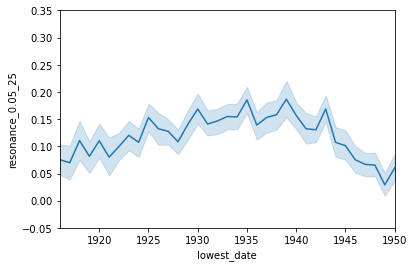

In [64]:
b = sns.lineplot(data = data, x = 'lowest_date', y = 'resonance_0.05_25')
b.set(xlim = (1916, 1950), ylim = (-0.05, 0.35))

[(1916.0, 1950.0), (-0.05, 0.35)]

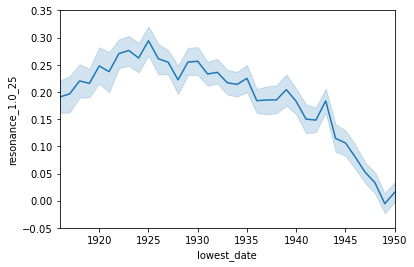

In [65]:
b = sns.lineplot(data = data, x = 'lowest_date', y = 'resonance_1.0_25')
b.set(xlim = (1916, 1950), ylim = (-0.05, 0.35))

Yes, there is definitely variation in these measures over time, especially if we use all the books. Why that is might be worth inquiring about. It looks a bit like something happened in the late 60s or 70s that made all late 1940s books different from their future -- at least in university libraries. Expanding range of author nationality?

But for the moment we can normalize the measures to z scores by year.

In [81]:
newdfs = []

for year, df in data.groupby('lowest_date'):
    df = df.loc[ : , ['resonance_0.05_25', 'resonance_1.0_25', 
                      'novelty_0.05_25', 'novelty_1.0_25',
                      'transience_0.05_25', 'transience_1.0_25']]
    df = df.apply(zscore)
    newdfs.append(df)

newvalues = pd.concat(newdfs)
newvalues.shape

(5494, 6)

In [82]:
newvalues.head()

,resonance_0.05_25,resonance_1.0_25,novelty_0.05_25,novelty_1.0_25,transience_0.05_25,transience_1.0_25
6,0.637911,0.158815,-0.031573,-0.399419,-0.323690,-0.431107
184,0.837914,0.734159,-0.641412,-1.228649,-0.997270,-1.418952
196,0.117854,-0.104286,0.663109,0.732698,0.578091,0.720137
212,-0.117550,-0.066820,0.992391,0.497163,1.000429,0.487150
282,-0.095962,-0.128271,0.238143,0.183749,0.271254,0.219192


In [83]:
for column in ['resonance_0.05_25', 'resonance_1.0_25', 'novelty_0.05_25', 
               'novelty_1.0_25', 'transience_0.05_25', 'transience_1.0_25']:
    data[column] = newvalues[column]  # and we trust the index will reorder values        

In [84]:
data.head(7)

,docid,tm_author,tm_title,tm_year,review_year,rownum,review_title,prize_author,bestseller_year,is_bestseller,...,lowest_date,standard_auth,review_wordcount,review_sentiment,novelty_1.0_25,novelty_0.05_25,transience_1.0_25,transience_0.05_25,resonance_1.0_25,resonance_0.05_25
0,uc1.b3347126,"shaw, irwin","welcome to the city, and other",1942.0,1942.0,3289.0,"welcome to the city, and other stories.",False,NaN,False,...,1942,"shaw, irwin",2400.0,3.715599,-0.006212,-0.235232,-0.319580,-0.712187,1.131303,0.907823
1,uc1.$b322688,"bennett, arnold",woman who stole everything,1927.0,1927.0,4140.0,"woman who stole everything, and other stories.",False,NaN,False,...,1927,"bennett, arnold",5010.0,3.500459,-0.718090,-1.012464,-0.793293,-1.128560,0.413321,0.154430
2,uc1.b3407035,"lippincott, joseph wharton",wilderness champion; the story,1944.0,1944.0,3481.0,wilderness champion; the story of a great houn...,False,NaN,False,...,1944,"lippincott, joseph w",600.0,3.759941,0.984460,0.961344,1.165411,1.658524,-0.401814,-0.920786
3,uc1.$b116192,"becker, may lamberton",golden tales of the southwest;,1939.0,1939.0,4283.0,golden tales of the southwest; selected with a...,False,NaN,False,...,1939,"becker, may lamberto",930.0,3.706520,-0.699861,-0.535305,-0.244554,0.109815,-1.319624,-0.974632
4,mdp.39015059415383,"miller, alice duer, mrs",instruments,1926.0,1926.0,2405.0,"instruments of darkness, and other stories.",False,NaN,False,...,1926,"miller, alice duer,",3600.0,3.613030,-1.482156,-1.927121,-1.360387,-1.544219,0.098821,-0.444320
5,mdp.39015002756842,"saroyan, william",daring young man on the flying,1934.0,1934.0,821.0,"the daring young man on the flying trapeze, an...",False,NaN,False,...,1934,"saroyan, william",4690.0,3.278887,0.138167,0.503598,-0.319603,-0.445469,1.297055,1.717866
6,umn.31951000955121j,"chase, mary ellen",girl from,1916.0,1916.0,2149.0,"girl from the big horn country, il",False,NaN,False,...,1916,"chase, mary ellen",960.0,3.911863,-0.399419,-0.031573,-0.431107,-0.323690,0.158815,0.637911


### Prizewinners and bestsellers: precocity

I originally compared these categories specifically to the "obscure" category, but that's not really fair. I think they should be compared to all non-prizewinner or non-bestseller books?

In [85]:
prizewinners = data.loc[data.prize_author == True, 'resonance_0.05_25']
not_prize = data.loc[data.prize_author == False, 'resonance_0.05_25']

In [86]:
ttest_ind(prizewinners, not_prize)

Ttest_indResult(statistic=3.2343608045698344, pvalue=0.0012263696756265622)

Definitely significant. A more interpretable measure of effect size is Cohen's *d*.

In [87]:
def cohens_d(a, b):
    cohens_d = (mean(a) - mean(b)) / (sqrt((stdev(a) ** 2 + stdev(b) ** 2) / 2))
    return cohens_d

In [88]:
cohens_d(prizewinners, not_prize)

0.18889722641422435

That's a smallish effect.

However, it's also not fair that we only have 1000 "obscure" books in this sample. In reality, they're going to be the bulk of the sample. So when we calculate a fuller sample, the effect of being a prizewinner will go up toward something a bit more like this:

In [89]:
obscure =  data.loc[data.obscure == True, 'resonance_0.05_25']
cohens_d(prizewinners, obscure)

0.35966608695633473

**Now let's do bestsellers.**

In [90]:
bestsellers = data.loc[data.is_bestseller == True, 'resonance_0.05_25']
not_best = data.loc[data.is_bestseller == False, 'resonance_0.05_25']

In [91]:
cohens_d(bestsellers, not_best)

0.16024914724082095

Lower than the prizewinners. But it could go up as high as:

In [92]:
cohens_d(bestsellers, obscure)

0.3446564045345326

The difference between bestsellers and prizewinners isn't statistically significant.

In [93]:
ttest_ind(bestsellers, prizewinners)

Ttest_indResult(statistic=-0.30466246250764106, pvalue=0.7607550144535895)

**Let's check the effect size if we use 100% of the books.**

In [94]:
prize_100 = data.loc[data.prize_author == True, 'resonance_1.0_25']
not_prize_100 = data.loc[data.prize_author == False, 'resonance_1.0_25']
cohens_d(prize_100, not_prize_100)

0.16861025059482382

Not all that different.

In [95]:
best_100 = data.loc[data.is_bestseller == True, 'resonance_1.0_25']
not_best_100 = data.loc[data.is_bestseller == False, 'resonance_1.0_25']
cohens_d(best_100, not_best_100)

0.1812765543225636

The effect sizes are very similar. The relative positions of prizewinners and bestsellers change, but we know that isn't significant anyway.

### Prizewinner and bestsellers: novelty

Does novelty follow the same pattern?

In [96]:
prize_nov = data.loc[data.prize_author == True, 'novelty_0.05_25']
not_prize_nov = data.loc[data.prize_author == False, 'novelty_0.05_25']
cohens_d(prize_nov, not_prize_nov)

-0.0006345305931677179

In [97]:
ttest_ind(prize_nov, not_prize_nov)

Ttest_indResult(statistic=-0.011117364311103385, pvalue=0.9911302131812985)

Virtually no effect. Note also that the effect gets *negative* if we include obscure books. Obscure (unreviewed) books are *more* novel than the prizewinners.

In [98]:
obscure_nov = data.loc[data.obscure == True, 'novelty_0.05_25']
cohens_d(prize_nov, obscure_nov)

-0.1423755499082056

In [99]:
best_nov = data.loc[data.is_bestseller == True, 'novelty_0.05_25']
not_best_nov = data.loc[data.is_bestseller == False, 'novelty_0.05_25']
cohens_d(best_nov, not_best_nov)

-0.3965679194612015

In [100]:
cohens_d(best_nov, obscure_nov)

-0.502990797361035

Bestsellers are extremely not-novel. This means that in order to exceed other books at precocity they must ...

In [101]:
best_tra = data.loc[data.is_bestseller == True, 'transience_0.05_25']
obscure_tra = data.loc[data.obscure == True, 'transience_0.05_25']
cohens_d(best_tra, obscure_tra)

-0.6949171071263002

... have even *lower* transience. Precocity is novelty minus transience.

This sort of makes sense. We might expect bestsellers to be fairly conservative, sticking close to patterns that have succeeded in the past and will succeed in the future.

### Review wordcount and sentiment

Wordcount is easy to compare, sentiment a little trickier.

We start by taking the Spearman correlation of precocity with wordcount. We're doing this across all books; unreviewed books have a wordcount of zero.

In [102]:
spearmanr(data['resonance_0.05_25'], data['review_wordcount'])

SpearmanrResult(correlation=0.15446333582301058, pvalue=1.1005841259436873e-30)

Cohen's $d = \frac{2 * r}{\sqrt{1 - r^2}}$

In [36]:
def r2d(r):
    d = (2*r) / sqrt(1 - r**2)
    return d

In [103]:
r2d(.15446)

0.31267236773024126

Right now this is higher than the effect size for bestsellers and prizewinners if we compare them across a comparable sample. All the effect sizes will probably get a bit stronger with more obscure books in the comparison, but the effect may be weaker for the wordcount. Excluding unreviewed books (below) doesn't greatly weaken the precocity correlation. So adding more of them may not strengthen it much either.

In [104]:
reviewed_precocity = data.loc[~pd.isnull(data.review_sentiment), 'resonance_0.05_25']
reviewed_words = data.loc[~pd.isnull(data.review_sentiment), 'review_wordcount']
spearmanr(reviewed_precocity, reviewed_words)

SpearmanrResult(correlation=0.1503140122721296, pvalue=3.629688352728203e-23)

**Association of novelty with wordcount.**

In [105]:
spearmanr(data['novelty_0.05_25'], data['review_wordcount'])

SpearmanrResult(correlation=-0.08041536805363055, pvalue=2.389739201433276e-09)

In [124]:
round(r2d(-0.080415), 4)

-0.1614

Very novel books are **less** likely to have a lot written about them. They have a lot of precocity because they nevertheless tend to resemble the future. In other words, transience is still low enough to make precocity positive.

In [125]:
spearmanr(data['transience_0.05_25'], data['review_wordcount'])

SpearmanrResult(correlation=-0.16853418732341552, pvalue=2.7464105183048828e-36)

**Now sentiment.** Sentiment is a little trickier because it doesn't make sense to treat the sentiment of unreviewed books as zero. So we have to actually select a subset where sentiment is non-null -- i.e. the subset of reviewed books.

In [107]:
reviewedresonance = data.loc[~pd.isnull(data.review_sentiment), 'resonance_0.05_25']
reviewedsentiment = data.loc[~pd.isnull(data.review_sentiment), 'review_sentiment']
spearmanr(reviewedresonance, reviewedsentiment)

SpearmanrResult(correlation=-0.04819610567477466, pvalue=0.0015644678260864826)

A weak *negative* correlation with resonance. But there are many reasons to be suspicious of sentiment measures. Note for instance that sentiment correlates *inversely* with wordcount.

In [108]:
spearmanr(reviewed_words, reviewedsentiment)

SpearmanrResult(correlation=-0.14495075108433872, pvalue=1.222586377701076e-21)

I suspect magazines that write long reviews are also more likely to write harsh reviews than those that are just producing a short "notice" of a book. Also the editors of BRD might be more likely to include a very harsh review to balance out perspectives on a book if it already has multiple reviews.

In [48]:
reviewedresonance100 = data.loc[~pd.isnull(data.review_sentiment), 'resonance_1.0_25']
reviewedsentiment = data.loc[~pd.isnull(data.review_sentiment), 'review_sentiment']
spearmanr(reviewedresonance100, reviewedsentiment)

SpearmanrResult(correlation=-0.10394820676349227, pvalue=8.185695092318713e-12)

If we look at 100% of the books, sentiment has a negative relationship to resonance. But again, we're going to need to look carefully at the sources of negative reviews before we know what this really means.

### Multivariate linear regression

In [109]:
import statsmodels.api as sm

In [115]:
X = sm.add_constant(data.loc[ : , ['review_wordcount', 'is_bestseller', 'prize_author']],
                    prepend = False)
X['is_bestseller'] = X['is_bestseller'].map({True: 1, False: 0})
X['prize_author'] = X['prize_author'].map({True: 1, False: 0})
y = data.loc[ : , 'resonance_0.05_25']

In [118]:
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      resonance_0.05_25   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     37.59
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           4.90e-24
Time:                        09:21:13   Log-Likelihood:                -7739.8
No. Observations:                5494   AIC:                         1.549e+04
Df Residuals:                    5490   BIC:                         1.551e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
review_wordcount  4.228e-05   4.23e-06  

If we include wordcount with the bestseller and prizewinner conditions, only wordcount is significant. Now, this may be partly because we have fuller data for wordcount.

**Let's try sentiment** across the rows where we have sentiment data.

In [120]:
X = sm.add_constant(data.loc[~pd.isnull(data.review_sentiment), ['review_wordcount', 'is_bestseller',
                                                                 'prize_author', 'review_sentiment']],
                    prepend = False)
X['is_bestseller'] = X['is_bestseller'].map({True: 1, False: 0})
X['prize_author'] = X['prize_author'].map({True: 1, False: 0})
y = data.loc[~pd.isnull(data.review_sentiment), 'resonance_0.05_25']
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      resonance_0.05_25   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     20.70
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           6.49e-17
Time:                        09:24:13   Log-Likelihood:                -5939.2
No. Observations:                4303   AIC:                         1.189e+04
Df Residuals:                    4298   BIC:                         1.192e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
review_wordcount  3.686e-05    4.9e-06  

If we include sentiment, it's an effective (negative) predictor across the rows where sentiment exists.

### Do we find an "inverse U"?

In other words, are books rewarded for achieving a medium level of "optimum differentiation" from the past?

Following the model of Silver, Childress, et al., we might expect review wordcount or review sentiment to peak at medium levels of novelty.

In [137]:
summarydf = data.loc[ : , ['review_wordcount', 'novelty_0.05_25', 'resonance_0.05_25']]
summarydf['relative_novelty'] = pd.qcut(summarydf['novelty_0.05_25'], 25, labels = False)
summarydf['relative_precocity'] = pd.qcut(summarydf['resonance_0.05_25'], 25, labels = False)
summarydf.head()

,review_wordcount,novelty_0.05_25,resonance_0.05_25,relative_novelty,relative_precocity
0,2400.0,-0.235232,0.907823,11,20
1,5010.0,-1.012464,0.154430,3,14
2,600.0,0.961344,-0.920786,21,3
3,930.0,-0.535305,-0.974632,7,3
4,3600.0,-1.927121,-0.444320,0,8


In [138]:
sns.set(rc = {'figure.figsize':(9,6)})

<AxesSubplot:xlabel='relative_novelty', ylabel='review_wordcount'>

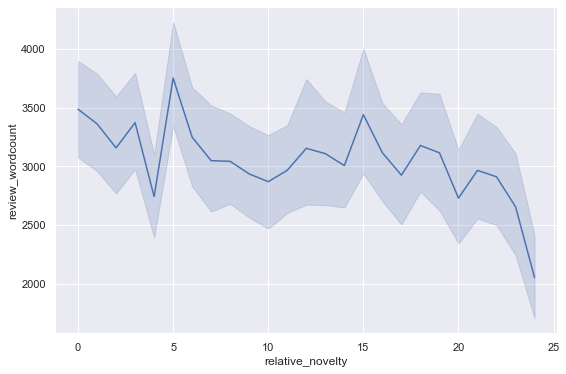

In [139]:
sns.lineplot(x = 'relative_novelty', y = 'review_wordcount', data = summarydf)

**That is not really an inverse U.** Less is written about a book as it gets more novel.

What if we try precocity?

<AxesSubplot:xlabel='relative_precocity', ylabel='review_wordcount'>

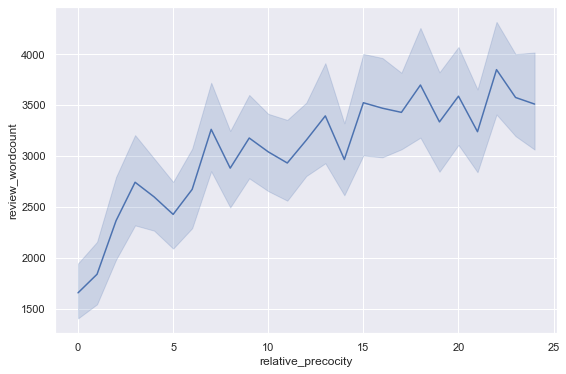

In [140]:
sns.lineplot(x = 'relative_precocity', y = 'review_wordcount', data = summarydf)

Still not an inverse U.

**What if we try with sentiment?**

In [143]:
summarydf = data.loc[~pd.isnull(data.review_sentiment), ['review_wordcount', 'review_sentiment',
                                                      'novelty_0.05_25', 'resonance_0.05_25']]
summarydf['relative_novelty'] = pd.qcut(summarydf['novelty_0.05_25'], 25, labels = False)
summarydf['relative_precocity'] = pd.qcut(summarydf['resonance_0.05_25'], 25, labels = False)
summarydf.head()

,review_wordcount,review_sentiment,novelty_0.05_25,resonance_0.05_25,relative_novelty,relative_precocity
0,2400.0,3.715599,-0.235232,0.907823,11,20
1,5010.0,3.500459,-1.012464,0.154430,3,14
2,600.0,3.759941,0.961344,-0.920786,21,3
3,930.0,3.706520,-0.535305,-0.974632,8,2
4,3600.0,3.613030,-1.927121,-0.444320,0,7


<AxesSubplot:xlabel='relative_novelty', ylabel='review_sentiment'>

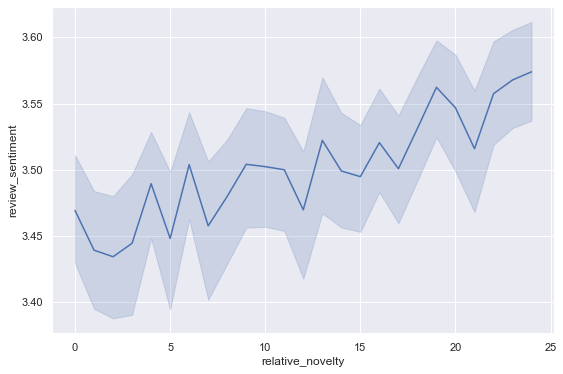

In [144]:
sns.lineplot(x = 'relative_novelty', y = 'review_sentiment', data = summarydf)

Still not an inverse U! Sentiment gets more positive as a book gets more novel.

### We could try to do the same thing for the cosine results

In [70]:
cosresults = pd.read_csv('results/centersurprise_0cossummary.tsv', sep = '\t', low_memory = False)

In [75]:
cosdata = meta.merge(cosresults, on = 'docid')
cosdata.shape

(5494, 24)